# Mass Gov Grants Project

DATA 297 RA

Zhou Zhou

## Summary

In this notebook, we will experiment with multiple methods to extract grants information, particularly those relased in tabular format, from pdfs and websites. We will start with grants information that can be extracted using open-source library first, and then advancing to **Adobe's proprietary API** when open-source library fails. We will also use **RPA** to programatically download the dataset from goverment website with built-in GIS tools and export function for the best result.

| Grants | Method |
| ------ | ------ |
|Competitive Green Communities|RPA|
|Buzzards Bay|RPA|
|Coastal Zone Management|RPA|
|Custainable Materials Recovery Program|Adobe API|
|Reduce, Reuse, Repair Micro Grant|Adobe API|
|Recycling & Reuse Business Development Grant|Adobe API|
|Commerical Refrigeration Grants|Mannual Input|
|Forestry Grants|Mannual Input|

While this notebook exported the converted information as `.csv` for collaboration purpose, it is **not** advised to do so since it may create unwanted **mojibake** in the output csv files.

## Prerequsite Package

In [ ]:
### Need for sure
# !pip install rpa
# !pip install bs4
# !pip install PyPDF2
# !pip install tabula
# !pip install tabula-py[jpype]
# !pip install openpyxl
# !pip install pyxlsb
# !pip install pdfservices-sdk
# !pip install selenium

In [2]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import PyPDF2
import tabula
import rpa as r
import time
import datetime
import re

## Open-sourced Package

This section will use `BeautifulSoup` and `tabula-py` to download pdfs from a select grant website, and then extract tabular information from pdfs and convert them into dataframe.

### Competitive Green Communities

#### Download the files

In [ ]:
import os
import requests
from bs4 import BeautifulSoup

# Function to extract URLs containing the keyword
def extract_files_urls(page_url, keyword):
    # Send a GET request to the webpage
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all links in the page
    links = soup.find_all('a', href=True)
    
    # Loop through each link and check if the link text contains the keyword
    files_links = []
    for link in links:
        if keyword.lower() in link.text.lower():  # Check if keyword is in the link text
            full_url = link['href']
            files_names = link
            if not full_url.startswith('http'):
                # If it's a relative link, make it absolute
                full_url = requests.compat.urljoin(page_url, full_url)
            files_links.append((link.text.strip(), full_url))
    
    return files_links

# Function to download files based on keyword and save in folder
def download_award_files(base_url, keyword, folder_name='.', file_format='pdf', file_name_loc=-2):
    
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Extract links that match the keyword
    filtered_links = extract_files_urls(base_url, keyword)
    
    # Download each file
    for link_text, link_url in filtered_links:  # Unpack the tuple
        # Construct the full URL
        if not link_url.startswith('http'):
            link_url = requests.compat.urljoin(base_url, link_url)
        # Extract the file name from the URL
        file_name = link_url.split('/')[-2] + file_format
        
        # Set the file path where it will be saved
        file_path = os.path.join(folder_name, file_name)
        
        # Download the file
        file_response = requests.get(link_url)
        if file_response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(file_response.content)
            print(f"Downloaded: {file_name}")
        else:
            print(f"Failed to download {file_name}. Status code: {file_response.status_code}")

cgc_url = 'https://www.mass.gov/lists/maps-reports-and-publications#maps-and-summaries-'
cgc_keyword = 'award'
cgc_folder_name = 'Competitive_green_communities_grant'
cgc_file_format = '.pdf'

download_award_files(cgc_url, cgc_keyword, cgc_folder_name, cgc_file_format)


`2164596.pdf` and `2047756.pdf` doesnt follow the naming convention, so we mannually rename them.

In [4]:
os.rename('Competitive_green_communities_grant/2164596.pdf', 'Competitive_green_communities_grant/table-of-2020-competitive-grant-awards-0.pdf')
os.rename('Competitive_green_communities_grant/2047756.pdf','Competitive_green_communities_grant/table-of-2019-competitive-grant-awards-0.pdf')

#### Convert to CSV/ dataframe

For demonstartion purpose, we will use open-source package `tabula` for converting PDF to CSV below. But for more constant result, Adobe's  [PDF Service API](https://developer.adobe.com/document-services/docs/overview/pdf-extract-api/howtos/extract-api/) is recommended.

In [ ]:
import tabula.io
import os
import pandas as pd
import re

# Define the directory where the PDFs are located
directory = 'Competitive_green_communities_grant'  # Replace with your actual directory if needed

# List to store all combined DataFrames
combined_data = []

# Function to extract the year from the folder
def extract_year_from_folder(filename):
    match = re.search(r'\d{4}', filename)
    if match:
        return match.group(0)
    else:
        return None

# Function to clean up column names
def clean_column_names(columns):
    # Replace spaces, newlines, and carriage returns with underscores
    return [col.lower().replace(' ', '_').replace('\r', '_').replace('\n', '_') for col in columns]

# Standard column names that we expect to appear in the DataFrames
standard_columns = ['municipality', 'grant_award', 'region', 'description_of_projects_funded', 'year']

# Loop through all PDF files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.pdf') and '2019' not in filename:
        file_path = os.path.join(directory, filename)
        
        # Read PDF into a DataFrame using tabula, handling all pages and lattice if needed
        df_list = tabula.io.read_pdf(file_path, pages='all', lattice=True)
        print(df_list)
        
        # If read_pdf returns a list of DataFrames (as it often does), combine them
        if isinstance(df_list, list) and len(df_list) > 0:
            df = pd.concat(df_list, ignore_index=True)
        else:
            df = df_list
        
        # Clean up column names
        df.columns = clean_column_names(df.columns)
        
        # Extract year from filename and add it as a column
        year = extract_year_from_folder(filename)
        df['year'] = year
        
        # Ensure all DataFrames have the same standard columns, filling missing ones with None
        for col in standard_columns:
            if col not in df.columns:
                df[col] = None
        
        # Reorder columns to match the standard
        df = df[standard_columns]
        
        # Append the cleaned DataFrame to the combined_data list
        combined_data.append(df)
        print(f"Processed {filename}, Year: {year}")

# Combine all DataFrames into one large DataFrame
combined_df = pd.concat(combined_data, ignore_index=True)

# Output the combined data for verification
print(combined_df.head())

# Optionally, save the combined DataFrame to a CSV
output_csv = 'cgc_combined_data.csv'
combined_df.to_csv(output_csv, index=False)
print(f"Combined data saved to {output_csv}")

[   Municipality Grant\rAward   Region  \
0         Adams     $161,373     West   
1    Ashburnham      $20,000  Central   
2         Ashby      $10,413  Central   
3         Athol     $111,514     West   
4     Attleboro     $186,629    South   
5   Bernardston      $13,805     West   
6     Billerica     $181,037    North   
7    Blackstone     $199,421  Central   
8     Brookline      $22,500    North   
9      Buckland       $5,000     West   
10   Chelmsford      $17,782    North   
11     Cohasset     $188,600    South   
12      Concord     $100,000    North   
13      Douglas     $104,947  Central   
14       Dudley     $200,000  Central   
15  Easthampton      $15,000     West   
16     Franklin     $150,902  Central   
17   Georgetown     $199,999    North   
18   Gloucester      $92,807    North   
19       Groton      $99,393  Central   
20      Hanover     $100,000    South   
21      Harwich     $160,952    South   
22      Hingham     $185,475    South   
23    Hopkinton

NameError: name 'extract_year_from_filename' is not defined

`table-of-2019-competitive-grant-awards-0.pdf` and `competitive-grant-awards-2023-block-2.pdf` has error in conversion, so we will mannual adjust them

I manually import the 2019 table here because the open-source library I tried generated weird formatting.  But this issue can be solved using [Adobe PDF Extract API](https://developer.adobe.com/document-services/docs/overview/pdf-extract-api/), as demonstrated later.

In [ ]:
cgc_2019_df = pd.read_excel('table-of-2019-competitive-grant-awards-0.xlsx', header=None) # Converted using Adobe API
col_headers = ['municipality', 'grant_award', 'region', 'description_of_projects_funded']
cgc_2019_df.columns = col_headers
cgc_2019_df['year'] = 2019
cgc_2019_df.head(5)

Swap some miss placing data, and merge 2019 and the rest of dataframe.

In [ ]:
# Swap the values of 'municipality' and 'grant_award' if 'municipality' starts with '$' or 'grant_award' is a number
def swap_values(row):
    if row['municipality'].startswith('$') or row['grant_award'].replace(',', '').isdigit():
        row['municipality'], row['grant_award'] = row['grant_award'], row['municipality']
    return row
combined_df = combined_df.apply(swap_values, axis=1)

# Merge cgc_2019_df and combined_df
cgc_df = pd.concat([combined_df, cgc_2019_df.iloc[1:]], ignore_index=True)
cgc_df.head(5)

In [ ]:
# Output the new DataFrame to a CSV file
output_csv = 'competitive_green_community_grant.csv'
cgc_df.to_csv(output_csv, index=False)

print(f"Combined data saved to {output_csv}")

###  Buzzards Bay

Buzzards Bay National Estuary Program proivdes a spreadsheet summary of past grant on their [website](https://buzzardsbay.org/our-program/funding/past-municipal-snep-grants-award/) with naming `BuzzardsBayNEP_grants_2000-2023.xlsx`. 

This file can be downloaded manually, or automated processes like RPA can be used. Assuming future files follow a similar naming convention, the URL format for downloading updates could be `https://buzzardsbay.org/download/BuzzardsBayNEP_grants_2000-lastest avaiable year.xlsx` format.

In [ ]:
# URL of the XLSX file
xlsx_url = "https://buzzardsbay.org/download/BuzzardsBayNEP_grants_2000-2023.xlsx"

# Custom headers (including a User-Agent to mimic a browser)
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

# Send a GET request to the URL with custom headers
response = requests.get(xlsx_url, headers=headers)
filename = os.path.basename(xlsx_url)

if response.status_code == 200:
    # Save the content to a file
    with open(filename, 'wb') as file:
        file.write(response.content)
    print(f"{filename} downloaded successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

In [ ]:
buzzards_bay_df = pd.read_excel(filename)
buzzards_bay_df.head(5)

In [2]:
## RPA

## RPA

We will cover this chapter for Coastal Zone Management Grants only since it is the only one with avaiable dataset for export. However, this method has huge potential as **Massachusetts' Gap Energy Grant** and **Water Resources Financial Grants** both have well-established map dataviusalization but very limited information elsewhere.

### Coastal Zone Management Grant

Coast Grant, Coastal Habitat, and Coast Resilence

The Massachusetts Office of Coastal Zone Management publishes grant information for the following programs on their interactive map, accessible via their website: [Grant Viewer](https://experience.arcgis.com/experience/68dc9fd4438544b1a39b48868c6f8f0c/page/Grant-Viewer/):
- Coastal Habitat
- Coastal Water Quality
- Coastal Pollutant Remediation

We can use Robotic Process Automation (RPA) to programmatically download this preprepared data and export it directly in formats like CSV, JSON, or GeoJSON. The rpa library enables us to automate browser actions, allowing us to interact with the website as if manually navigating it.

 The code below is designed to extract data from the ["Grant Viewer"](https://experience.arcgis.com/experience/68dc9fd4438544b1a39b48868c6f8f0c/page/Grant-Viewer/) website. The script automatically performs actions to:

- Open the website
- Navigate through its data table interface
- Export the table data directly as a CSV file

Though specific steps may vary across websites, the overall logic is similar and can be adapted for other sites. This approach allows us to gather data quickly and efficiently, making it ideal for repetitive tasks or large-scale data collection.

In [1]:
# Define the URL of the target webpage, specifically the "Grant Viewer" page on ArcGIS Experience
czm_url = 'https://experience.arcgis.com/experience/68dc9fd4438544b1a39b48868c6f8f0c/page/Grant-Viewer/'

# Import the RPA (Robotic Process Automation) library for automating browser actions
import rpa as r 

# Initialize RPA with Chrome as the chosen browser
r.init(chrome_browser=True)

# Open the specified URL in the Chrome browser
r.url(czm_url)

# (Optional) Click on an 'OK' button if needed for any pop-up dialog or alert
# r.click('OK')

# Wait for 1 second to allow the page to load before proceeding
r.wait(1)

# Click the 'View Table' button to display the data table on the webpage
r.click('View Table')

# Wait for 1 second to ensure the table is fully loaded
r.wait(1)

# Click the 'Actions' button to reveal additional options for the data
r.click('Actions')

# Wait for 1 second to let the actions menu appear
r.wait(1)

# Click the 'Export' option to initiate the export process
r.click('Export')

# Wait for 1 second to ensure the export options are fully loaded
r.wait(1)

# Click on 'Export to CSV' to download the table data as a CSV file
r.click('Export to CSV')

# Wait 15 seconds to allow sufficient time for the file download to complete
r.wait(15)

# Close the RPA session and the browser
r.close()


: 

: 

In [ ]:
### Read the CZM grant csv file
import os
import pandas as pd
cd = os.getcwd()

files_in_directory = os.listdir(cd)
# Filter CSV files to include only those with 'CZM' in the file name
czm_csv_files = [file for file in files_in_directory if 'CZM' in file and file.endswith('.csv')]

if czm_csv_files:
    czm_df = pd.read_csv(czm_csv_files[0])
else:
    print("No CZM Grant csv file found.")
czm_df = pd.read_csv(czm_csv_files[0])
czm_df

# Reorder the columns
columns_to_front = ['YEAR','TOWN', 'PROJECT TITLE', 'GRANT_AWARD','PROJECT DESCRIPTION','GRANT PROGRAM', 'GlobalID','x', 'y']
remaining_columns = [col for col in czm_df.columns if col not in columns_to_front]
new_column_order = columns_to_front + remaining_columns

# Create a new DataFrame with the reordered columns
czm_df_reordered = czm_df[new_column_order]
czm_df_reordered.head(5)
czm_df

In [11]:
os.rename(str(czm_csv_files[0]),'CZM_Grants.csv')

## Adobe API


In some cases, open-source packages may fail to provide usable results for PDF extraction.  The [Adobe Extract PDF API](https://developer.adobe.com/document-services/docs/overview/pdf-extract-api/) offers a reliable alternative with robust functionality for parsing complex PDF documents.

Currently, the directories in this section are hardcoded. These folders were created when downloading PDF files from various websites, each using unique naming conventions for the files. Here's an example directory structure for reference:

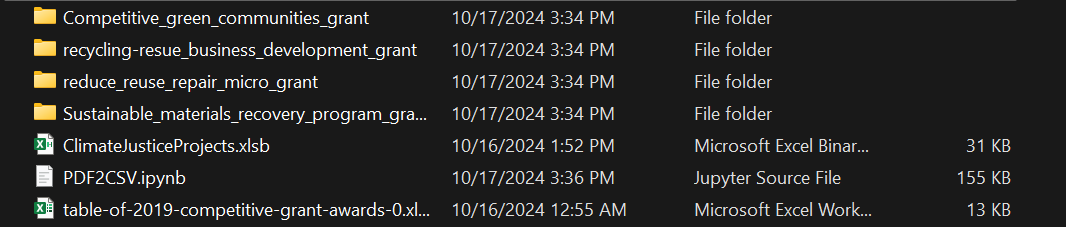

In [41]:
import logging
import os
from datetime import datetime
from adobe.pdfservices.operation.auth.service_principal_credentials import ServicePrincipalCredentials
from adobe.pdfservices.operation.exception.exceptions import ServiceApiException, ServiceUsageException, SdkException
from adobe.pdfservices.operation.io.cloud_asset import CloudAsset
from adobe.pdfservices.operation.io.stream_asset import StreamAsset
from adobe.pdfservices.operation.pdf_services import PDFServices
from adobe.pdfservices.operation.pdf_services_media_type import PDFServicesMediaType
from adobe.pdfservices.operation.pdfjobs.jobs.extract_pdf_job import ExtractPDFJob
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_element_type import ExtractElementType
from adobe.pdfservices.operation.pdfjobs.params.extract_pdf.extract_pdf_params import ExtractPDFParams
from adobe.pdfservices.operation.pdfjobs.result.extract_pdf_result import ExtractPDFResult

# Initialize the logger
logging.basicConfig(level=logging.INFO)

class ExtractTextTableInfoFromPDF:
    def __init__(self, directory):
        self.directory = directory
        self.credentials = ServicePrincipalCredentials(
            client_id='Replace with your own client_id',   ## Replace with your own client_id
            client_secret='Replace with your own client_secret'  ## Replace with your own client_secret
        )
        self.pdf_services = PDFServices(credentials=self.credentials)

    def process_pdfs(self):
        for filename in os.listdir(self.directory):
            if filename.endswith('.pdf'):
                file_path = os.path.join(self.directory, filename)
                self.extract_text_table_info(file_path)

    def extract_text_table_info(self, file_path):
        try:
            with open(file_path, 'rb') as file:
                input_stream = file.read()

            # Creates an asset(s) from source file(s) and upload
            input_asset = self.pdf_services.upload(input_stream=input_stream, mime_type=PDFServicesMediaType.PDF)

            # Create parameters for the job
            extract_pdf_params = ExtractPDFParams(
                elements_to_extract=[ExtractElementType.TEXT, ExtractElementType.TABLES],
            )

            # Creates a new job instance
            extract_pdf_job = ExtractPDFJob(input_asset=input_asset, extract_pdf_params=extract_pdf_params)

            # Submit the job and gets the job result
            location = self.pdf_services.submit(extract_pdf_job)
            pdf_services_response = self.pdf_services.get_job_result(location, ExtractPDFResult)

            # Get content from the resulting asset(s)
            result_asset: CloudAsset = pdf_services_response.get_result().get_resource()
            stream_asset: StreamAsset = self.pdf_services.get_content(result_asset)

            # Creates an output stream and copy stream asset's content to it
            output_file_path = self.create_output_file_path(file_path)
            with open(output_file_path, "wb") as file:
                file.write(stream_asset.get_input_stream())

            logging.info(f"Processed {file_path} successfully.")

        except (ServiceApiException, ServiceUsageException, SdkException) as e:
            logging.exception(f'Exception encountered while executing operation: {e}')

    # Generates a string containing a directory structure and file name for the output file
    @staticmethod
    def create_output_file_path(input_file_path) -> str:
        now = datetime.now()
        time_stamp = now.strftime("%Y-%m-%dT%H-%M-%S")
        base_name = os.path.basename(input_file_path).replace('.pdf', '')
        output_dir = os.path.dirname(input_file_path)
        os.makedirs(output_dir, exist_ok=True)
        return os.path.join(output_dir, f"{base_name}.zip")


if __name__ == "__main__":
    directory = os.getcwd()
    extractor = ExtractTextTableInfoFromPDF(directory)
    extractor.process_pdfs()

#### Unzip and Convert `xlsx` into dataframe

In [34]:
import zipfile
import os

def unzip_csv_files_in_directory(directory_path):
    # Create the output folder if it doesn't exist
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    
    # Iterate over each file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.zip'):
            zip_file_path = os.path.join(directory_path, filename)
            # Open the zip file
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                # Iterate over each file in the zip file
                for file_info in zip_ref.infolist():
                    # Check if the file is in the 'tables' folder and is a CSV file
                    new_diectory_path = zip_file_path.replace('.zip','')
                    if file_info.filename.startswith('tables'):
                        # Extract the file to the output folder
                        zip_ref.extract(file_info, new_diectory_path)
                        print(f"Extracted: {file_info.filename}")

In [35]:
# Convert                        
def read_csv(directory):
    combined_df = pd.DataFrame()
    
    # Iterate over each file in the directory
    for filename in os.listdir(directory):
        folder_path = os.path.join(directory, filename)
        if os.path.isdir(folder_path):
            tables_path = os.path.join(folder_path, 'tables')
            print(tables_path)
            for file in os.listdir(tables_path):
                if file.endswith('.xlsx'):
                    file_path = os.path.join(tables_path, file)
                    df = pd.read_excel(file_path)
                    if any('_x000D_' in col for col in df.columns):
                        df.columns = df.columns.str.replace(' _x000D_', '', regex=False) # Remove '_x000D_' from column names 
                        df = df.replace(' _x000D_', '', regex=True)
                    # Extract the year from the file path
                    year_match = re.search(r'\d{4}', file_path)
                    year = year_match.group(0) if year_match else 0
                    df['year'] = year
                    
                    combined_df = pd.concat([combined_df, df], ignore_index=True)
    return combined_df

In [36]:
# Save merged df into csv
def save_csv(df, output_filename, output_type='.csv'):
    output_file_path = os.path.join(os.getcwd(), (output_filename + output_type))
    df.to_csv(output_file_path, index=False, encoding='utf-8')
    print(f"DataFrame successfully saved to {output_file_path}")

### Sustainable Materials Recovery Program (SMRP) Municipal Grant

In [ ]:
smrp_url = 'https://www.mass.gov/how-to/apply-for-a-sustainable-materials-recovery-program-smrp-municipal-grant'
smrp_keyword = 'award'
smrp_folder_name = 'Sustainable_materials_recovery_program_grant'
smrp_file_format = '.pdf'

download_award_files(smrp_url, smrp_keyword, smrp_folder_name, smrp_file_format)

In [ ]:
extractor = ExtractTextTableInfoFromPDF(smrp_folder_name)
extractor.process_pdfs()

In [25]:
unzip_csv_files_in_directory(smrp_folder_name)

Extracted: tables/fileoutpart1.xlsx
Extracted: tables/fileoutpart0.xlsx
Extracted: tables/fileoutpart3.xlsx
Extracted: tables/fileoutpart2.xlsx
Extracted: tables/fileoutpart1.xlsx
Extracted: tables/fileoutpart0.xlsx
Extracted: tables/fileoutpart3.xlsx
Extracted: tables/fileoutpart2.xlsx
Extracted: tables/fileoutpart1.xlsx
Extracted: tables/fileoutpart0.xlsx
Extracted: tables/fileoutpart3.xlsx
Extracted: tables/fileoutpart2.xlsx
Extracted: tables/fileoutpart1.xlsx
Extracted: tables/fileoutpart0.xlsx
Extracted: tables/fileoutpart3.xlsx
Extracted: tables/fileoutpart2.xlsx
Extracted: tables/fileoutpart1.xlsx
Extracted: tables/fileoutpart5.xlsx
Extracted: tables/fileoutpart4.xlsx
Extracted: tables/fileoutpart0.xlsx
Extracted: tables/fileoutpart3.xlsx
Extracted: tables/fileoutpart6.xlsx
Extracted: tables/fileoutpart2.xlsx
Extracted: tables/fileoutpart1.xlsx
Extracted: tables/fileoutpart4.xlsx
Extracted: tables/fileoutpart0.xlsx
Extracted: tables/fileoutpart3.xlsx
Extracted: tables/fileoutpar

In [32]:
import os
import pandas as pd
import re

def read_and_combine_xlsx(directory):
    combined_df = pd.DataFrame()
    headers_list = []
    output_path =  []
    file_name = ''

    # Iterate over each file in the directory
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        i = 0
        if os.path.isdir(folder_path):
            tables_path = os.path.join(folder_path, 'tables')
            if os.path.exists(tables_path):
                for file in os.listdir(tables_path):
                    if file.endswith('.xlsx'):
                        file_path = os.path.join(tables_path, file)                    
                        df = pd.read_excel(file_path)

                        # Remove '_x000D_' from column names and data
                        df.columns = df.columns.str.replace('_x000D_', '', regex=False)
                        df = df.replace('_x000D_', '', regex=True)
                        headers_list.append(df.columns.to_list())
                        # Extract the year from the file path
                        year_match = re.search(r'\d{4}', file_path)
                        year = year_match.group(0) if year_match else 0
                        df['year'] = year
                        
                        # Concatenate the data
                        combined_df = pd.concat([combined_df, df], ignore_index=True)
                        file_name = f"{year}_{i}.csv"
                        output_path = os.path.join(directory, file_name)
                        if os.path.exists(output_path):
                            i += 1
            combined_df.to_csv(output_path, index=False)
    
    # Create a DataFrame from the collected headers
    headers_df = pd.DataFrame(headers_list)
    
    return combined_df, headers_df

# Example usage
smrp_folder_name = 'Sustainable_materials_recovery_program_grant'
combined_df, headers_df = read_and_combine_xlsx(smrp_folder_name)

# Display the first few rows of combined data and headers
headers_df


,0,1,2,3
0,Grantee,Grant Description,Amount Awarded,None
1,Grantee,Grant Description,Amount Awarded,None
2,Grantee,Grant Description,Amount Awarded,None
3,Grantee,Grant Description,Amount Awarded,None
4,Grantee,Item,Amount,None
...,...,...,...,...
89,Grantee,Item,Amount,None
90,Grantee,Item,Amount,None
91,Grantee,Item,Amount,None
92,Grantee,Item,Amount,None


In [ ]:
df_smrp = read_csv(smrp_folder_name)
df_smrp.head(5)

In [20]:
save_csv(df_smrp, 'Sustainable_materials_recovery_program_grant')

DataFrame successfully saved to c:\Users\ZHOUZ\Desktop\Document\aTufts\24 Fall\DATA 297 RA\Sustainable_materials_recovery_program_grant.csv


### MassDEP Reduce, Reuse, Repair Micro-Grant

In [7]:
rrr_url = 'https://www.mass.gov/how-to/massdep-reduce-reuse-repair-micro-grant'
rrr_keyword = 'awards'
rrr_folder_name = 'reduce_reuse_repair_micro_grant'
rrr_file_format = '.pdf'

download_award_files(rrr_url, rrr_keyword, rrr_folder_name, rrr_file_format)

In [ ]:
extractor = ExtractTextTableInfoFromPDF(rrr_folder_name)
extractor.process_pdfs()

In [15]:
unzip_csv_files_in_directory(rrr_folder_name)

Extracted: tables/fileoutpart0.xlsx


In [21]:
df_rrr = read_csv(rrr_folder_name)
df_rrr['Fiscal Year'] = df_rrr['Fiscal Year'].str.replace('FY', '20')
df_rrr.head(5)

reduce_reuse_repair_micro_grant\micro-grant-awards-since-2019_extract_2024-10-17T14-37-50\tables


,Fiscal Year,Grantee,Project Title,Location,Award Amount,year
0,2019,Fresh Start Furniture Bank,Bulk Furniture Loading Dock,Hudson,"$ 3,150.00",2019
1,2019,"Roots & Dreams and Mustard Seed, Inc",The BagShare Pittsfield Chapter/Roots & Dreams,Pittsfield,"$ 5,000.00",2019
2,2019,More Than Words,More Than Words Used Textile Collection,Waltham,"$ 5,000.00",2019
3,2019,"Berkshire Environmental Action Team, LLC.",Berkshire Zero-Waste Initiative,Pittsfield,"$ 5,000.00",2019
4,2019,Town of Rowe,Rowe Town Library - Library of Things,Rowe,"$ 2,500.00",2019


In [22]:
save_csv(df_rrr, rrr_folder_name)

DataFrame successfully saved to c:\Users\ZHOUZ\Desktop\Document\aTufts\24 Fall\DATA 297 RA\reduce_reuse_repair_micro_grant.csv


### Recycling & Reuse Business Development Grant

In [ ]:
rrbd_url = 'https://www.mass.gov/how-to/apply-for-a-recycling-reuse-business-development-grant'
rrbd_keyword = 'award'
rrbd_folder_name = 'recycling-resue_business_development_grant'
rrbd_file_format = '.pdf'

download_award_files(rrbd_url, rrbd_keyword, rrbd_folder_name, rrbd_file_format)

In [ ]:
extractor = ExtractTextTableInfoFromPDF(rrbd_folder_name)
extractor.process_pdfs()

In [10]:
unzip_csv_files_in_directory(rrbd_folder_name)
df_rrbd = read_csv(rrbd_folder_name)
df_rrbd.head(5)
df_rrbd.rename(columns={df_rrbd.columns[1]: 'Location'}, inplace=True)

NameError: name 'rrbd_folder_name' is not defined

In [ ]:
save_csv(df_rrbd, rrbd_folder_name)

## Mannual Input (Temp Solution)

Grants data in this section are entered mannual due to not many of them. It could be use 

### MassDEP Commercial Refrigeration Grant

Because the commerical refrigeration grant only has 1 year of data with 4 grants published as press release. We will mannual input here for now.

In [ ]:
data = [
    {
        "Project Name": "Fruit Life, Inc.",
        "Town Name": "Chicopee",
        "Amount": 200000,
        "Description": "for a new CO2 system at an existing store"
    },
    {
        "Project Name": "Souper Sweet Sandwich Shop, Inc.",
        "Town Name": "Springfield",
        "Amount": 18179,
        "Description": "for a propane retrofit and system expansion at an existing store"
    },
    {
        "Project Name": "The Food Bank of Western Massachusetts",
        "Town Name": "Hadley",
        "Amount": 50000,
        "Description": "to switch to a CO2 system"
    },
    {
        "Project Name": "Big Y Foods, Inc.",
        "Town Name": "Northampton, Palmer, Springfield (2), Wilbraham",
        "Amount": 238507,
        "Description": "for five system retrofits for lower GWP refrigerants and improved leak detection in supermarkets"
    },
    {
        "Project Name": "ALDI, Inc.",
        "Town Name": "Northampton",
        "Amount": 75000,
        "Description": "for a new CO2 system at a new store"
    }
]

# Creating the DataFrame
commerical_refrige_df = pd.DataFrame(data)
commerical_refrige_df['year'] = 2023
commerical_refrige_df

In [8]:
# save commerical_refrige_df as csv
commerical_refrige_df.to_csv('commerical_refrige.csv', index=False)

Same for forestry grants.

### Forestry Grants

In [32]:
import pandas as pd

forestry_df = data = {
    "Town": ["Sturbridge", "Holland", "Pelham"],
    "Amount": [400000, 215000, 375124],
    "Purpose": ["To conserve 280 acres in Sturbridge as a community forest", 
                "To conserve 153 acres in Holland as a community forest", 
                "To conserve 185 acres in Pelham as a community forest"],
    "Year": [2014, 2019, 2016]
}
forestry_df = pd.DataFrame(forestry_df)
forestry_df


,Town,Amount,Purpose,Year
0,Sturbridge,400000,To conserve 280 acres in Sturbridge as a commu...,2014
1,Holland,215000,To conserve 153 acres in Holland as a communit...,2019
2,Pelham,375124,To conserve 185 acres in Pelham as a community...,2016


## Text / HTML

### [Water Management Act Grant Programs for Public Water Suppliers](https://www.mass.gov/info-details/water-management-act-grant-programs-for-public-water-suppliers)

Due to the inconsistent format of these pdf files, even the Adobe API will struggle to generate a output constantly. Thus, we suggestd to leverage the power of LLM such as **ChatGPT** that doesn't require the user to define a set of rules for extracting the information. Due to resources constraint, we were not able to experiment with ChatGPT API to establish a full pipleline in the notebook, and had to rely on mannually upload downloaded pdfs to the free ChatGPT web interface.

In [ ]:
wmag_url = 'https://www.mass.gov/info-details/water-management-act-grant-programs-for-public-water-suppliers'
wmag_keyword = 'SWMI Grant'
wmag_folder_name = 'Water_Management_Act_Grant'
wmag_file_format = '.pdf'

download_award_files(wmag_url, wmag_keyword, wmag_folder_name, wmag_file_format)

Downloaded: swmi-grant-report-summaries-for-2022-2023.pdf
Downloaded: swmi-grant-report-summaries-for-2021-2022.pdf
Downloaded: swmi-grant-report-summaries-for-2020-2021.pdf
Downloaded: swmi-grant-report-summaries-for-2019-2020.pdf
Downloaded: swmi-grant-report-summaries-for-2018-2019.pdf
Downloaded: swmi-grant-report-summaries-for-2017-2018.pdf
Downloaded: swmi-grant-report-summaries-for-2016-2017.pdf
Downloaded: swmi-grant-report-summaries-for-2014-2015.pdf
Downloaded: swmi-grant-report-summaries-for-2013-2014.pdf
Downloaded: swmi-grant-report-summaries-for-2012-2013.pdf


### [Turi Grants](https://www.turi.org/grants/)

We can obtain the HTML from the **TURI Grant** website and use human-defined phrasing rules to separate the content into `project`, `town name`, `description`, `amount`, and `year` columns. But I opted for the same ChatGPT approach here since it can perform the cleanning process and Name Entity Recongition to extract the location at the same time.

Please note that the TURI grant only publishes the total funds awarded to multiple awardees within a single year, so it is not possible to determine the specific grant amount for each project. One approach is to assume the grant is equally distributed among grantees each year; while this may not be precise, it ensures the total grant amount is not duplicated. We will add a sentence in the description to clarify this approach.

In [ ]:
from selenium import webdriver

# Set up Selenium with ChromeDriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')  # Run in headless mode

# Start the WebDriver
driver = webdriver.Chrome(options=chrome_options)

# Open the target URL and get page source
turi_url = 'https://www.turi.org/grants/'
driver.get(turi_url)
turi_html = driver.page_source
print(driver.page_source)

# Close the driver
driver.quit()